# MESA session 4: solution notebook


In [1]:
import os
import numpy as np
import mesa_reader as mr
import matplotlib.pyplot as plt 
import astropy.units as u
import astropy.constants as const


***
# 1. X-ray binaries

## a) 

inlist --> inlist_project

inlist_project contains some general binay mass transfer settings and sets the masses of the donor (star 1) and accretor/companion (star 2). 
This further points to the donor inlists: 
inlist1 --> inlist1_spec and inlist_massive_defaults

and accretor inlists:
inlist2 --> inlist2_spec and again inlist_massive_defaults




## b) 

Kepler: 

$$
\frac{P^2}{(2\pi)^2} = \frac{a^3}{GM_{tot}}
$$


The Roche radius is approximately:

$$
R_{rl} = a \times 0.44 \frac{q^{0.33}}{(1 + q)^{0.22}}
$$

In [ ]:
def kepler(m1, m2, P = None, a = None):
    """
    Given orbital period P return semi-major axis a 
    Given semi-major axis a and total mass Mtot 
    values are assumed to be delivered with units
    """
    m1 = m1.to(u.kg)
    m2 = m2.to(u.kg)
    Mtot = m1 + m2

    if P is not None:
        P = P.to(u.s)
        a = (const.G * Mtot * (P / (2*np.pi))**2) ** (1/3)
        return a.to(u.Rsun)

    if a is not None:
        a = a.to(u.m)
        P = 2*np.pi * np.sqrt(a**3 / (const.G * Mtot))
        return P.to(u.days)


def roche_radius(a, q):
    """
    a Orbital separation.
    q : M_donor / M_accretor.
    -------
    Rrl : Roche radius in same units as a.
    """
    return a * 0.44 * q**0.33 / (1 + q)**0.22


In [13]:
M1 = 12.3*u.Msun # donor
M2 = 4.3*u.Msun # donor

a = kepler(M1, M2, P = 13*u.day, a = None)
print(f'Semi major axis of system {a}')

print(f"This means that the Roche radius of the donor is {roche_radius(a, M1/M2)}")



Semi major axis of system 59.35209523699168 solRad
This means that the Roche radius of the donor is 27.44429688280183 solRad


We know from previous MESA sessions that 15Msun stars get to about 10 solar radii by the end of its main-sequence ( < case A), but has reached hundreds (to almost a 1000) solar radi at the tip of the giant branch when He ignites (> case C). 
Since the stars roche radius is somewhere in between at about 30Rsun, the we expect the star to experience case B mass transfer.

Let's reuse our HR diagram plotter from last time: 

In [30]:
# Define a HR diagram plotting function that we can re-use
def HR_diagram(histoy_list, xlim=(None, None), ylim=(None, None),
               VMIN=-3, VMAX=0, cmap_name = 'rainbow', 
               colour_by='center_h1', colour_label='kleur',
               save_loc='./plots/'):
    """
    Plot a HR diagram from a list of mesa history data files.

    """

    fig, ax = plt.subplots(figsize=(10, 8))

    # Function to calc R from stefan-boltzmann law
    def Radius(Teff, L):
        Teff = Teff * u.K
        L = (L * u.Lsun).to(u.W)
        R = (L / (4 * np.pi * const.sigma_sb * Teff**4))**0.5
        return R.to(u.Rsun).value

    # --- Radius contour grid ---
    Teffs = np.linspace(3.5, 8, 100)
    Ls = np.linspace(0.5, 5.0, 100)
    Teffs_grid, Ls_grid = np.meshgrid(Teffs, Ls)
    Radius_grid = Radius(10**Teffs_grid, 10**Ls_grid)

    CS = ax.contour(Teffs_grid, Ls_grid, Radius_grid,
                    levels=[1, 10, 100, 1e3, 1e4],
                    colors='#969696', linestyles='dashed')
    ax.clabel(CS, inline=1, inline_spacing=-5, fontsize=15)
            #   manual=[(4.5, 3.2), (3.9, 3.2), (3.5, 3.2), (2.5, 3.2), (1.5, 3.1)])

    # --- Plot each star ---     
    for i, hist in enumerate(histoy_list):
        # find where to start the center h drops below 0.69
        start = np.flatnonzero(np.asarray(hist.center_h1) < 0.69)[0] if (np.asarray(hist.center_h1) < 0.69).any() else 0

        # get relevant data from the start of MS to 
        log_Teff = hist.log_Teff[start:] 
        log_L    = hist.log_L[start:] 
        C        = np.asarray(getattr(hist, colour_by))[start:]

        scat = ax.scatter(log_Teff, log_L, c=C, cmap = cmap_name, vmin=VMIN, vmax=VMAX, s=8)

        # Annotate the mass of the star at the start of the MS
        ax.scatter(log_Teff[0], log_L[0], marker='*', s=50)
        ax.text(log_Teff[0],  log_L[0] , f"${np.round(hist.star_mass[0], 1)}$"+"M$_{\odot}$",
                 ha='right', va='top', fontsize = 15) #log_Teff

    cb = plt.colorbar(scat, ax=ax)
    cb.set_label(colour_label if colour_label else (f"{colour_by} / L" if Lfrac else colour_by), fontsize=20)

    # -- Plot values -- 
    ax.set_xlabel('log$_{10}$(T$_{eff}$/K)', fontsize=25)
    ax.set_ylabel('log$_{10}$(L/L$_{\\odot}$)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    if xlim != (None, None): ax.set_xlim(xlim)
    if ylim != (None, None): ax.set_ylim(ylim)
    ax.invert_xaxis()
    fig.tight_layout()

    os.makedirs(save_loc, exist_ok=True)
    out = os.path.join(save_loc, f"HR_{colour_by}.png")
    plt.savefig(out, bbox_inches='tight')
    plt.show()
    return 


## HR diagram

In [36]:
donor_history.bulk_names


('model_number',
 'num_zones',
 'star_age',
 'log_dt',
 'star_mass',
 'log_xmstar',
 'log_abs_mdot',
 'mass_conv_core',
 'conv_mx1_top',
 'conv_mx1_bot',
 'conv_mx2_top',
 'conv_mx2_bot',
 'mx1_top',
 'mx1_bot',
 'mx2_top',
 'mx2_bot',
 'mix_type_1',
 'mix_qtop_1',
 'mix_type_2',
 'mix_qtop_2',
 'mix_type_3',
 'mix_qtop_3',
 'mix_type_4',
 'mix_qtop_4',
 'mix_type_5',
 'mix_qtop_5',
 'mix_type_6',
 'mix_qtop_6',
 'mix_type_7',
 'mix_qtop_7',
 'mix_type_8',
 'mix_qtop_8',
 'mix_type_9',
 'mix_qtop_9',
 'mix_type_10',
 'mix_qtop_10',
 'log_LH',
 'log_LHe',
 'log_LZ',
 'log_Lnuc',
 'pp',
 'cno',
 'tri_alfa',
 'epsnuc_M_1',
 'epsnuc_M_2',
 'epsnuc_M_3',
 'epsnuc_M_4',
 'epsnuc_M_5',
 'epsnuc_M_6',
 'epsnuc_M_7',
 'epsnuc_M_8',
 'burn_type_1',
 'burn_qtop_1',
 'burn_type_2',
 'burn_qtop_2',
 'burn_type_3',
 'burn_qtop_3',
 'burn_type_4',
 'burn_qtop_4',
 'burn_type_5',
 'burn_qtop_5',
 'burn_type_6',
 'burn_qtop_6',
 'burn_type_7',
 'burn_qtop_7',
 'burn_type_8',
 'burn_qtop_8',
 'burn_type

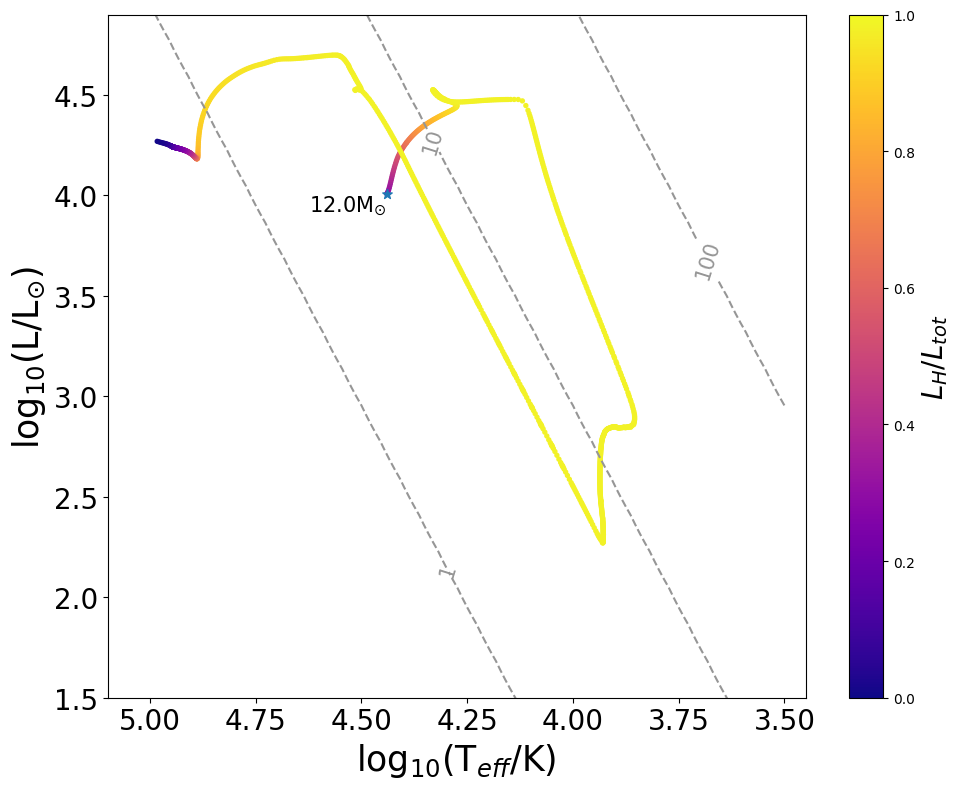

In [ ]:
# Load your computed models
donor_history = mr.MesaData('./data/session4_work/LOGS1/history.data')


HR_diagram([donor_history],
           xlim=(3.45, 5.1), ylim=(1.5, 4.9),
           VMIN=0, VMAX=1, cmap_name = 'plasma',
           colour_by='center_he4', colour_label='$L_{He}$/$L_{tot}$')


## 3a ) 
We see that the star indeed starts RLOF post while on the Hertszprung gap. 
From that point onwards it is very different from 'normal' single stellar evolution. 
The star plummets to low luminosities, this is caused by the strong thermal disequilibrium of the primary: a radiative donor star shrinks in response to mass loss and has to re-expand to regain thermal equilibrium. This requiresthe absorption of gravitational energy, so that the surface luminosity during thermal-timescale mass transfer is (much) smaller than the nuclear luminosity provided by the H-burning shell.


The star stops mass transferring when essentially the whole envelope is lost, when the mass transfer nears the core, it no longer responds to mass loss as a radiative envelope. We see from the colours that He ignition starts not much later. 

The star is very luminour and hot post mass transfer: it looks like a stripped He star!



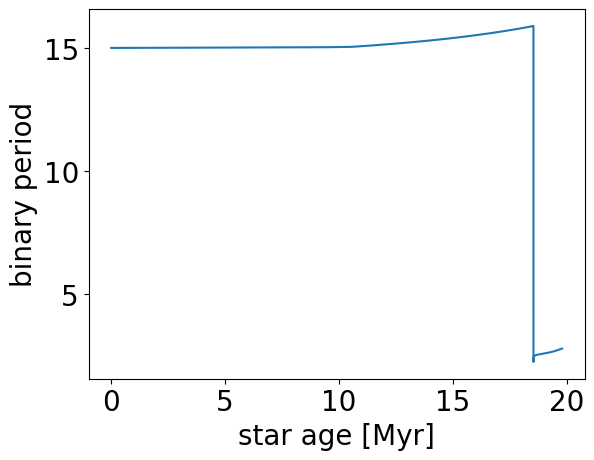

In [50]:
binary_history = mr.MesaData('./data/session4_work/binary_history.data')

binary_history.bulk_names

plt.plot(binary_history.age/1e6, binary_history.period_days)
plt.xlabel('star age [Myr]',fontsize = 20)
plt.ylabel('binary period',fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.show()

We see that the binary orbit shrinks during mass transfer

In [46]:
# donor_history.bulk_names
binary_history.bulk_names


('model_number',
 'age',
 'period_days',
 'binary_separation',
 'v_orb_1',
 'v_orb_2',
 'rl_1',
 'rl_2',
 'rl_relative_overflow_1',
 'rl_relative_overflow_2',
 'star_1_mass',
 'star_2_mass',
 'lg_mtransfer_rate',
 'lg_mstar_dot_1',
 'lg_mstar_dot_2',
 'lg_system_mdot_1',
 'lg_system_mdot_2',
 'lg_wind_mdot_1',
 'lg_wind_mdot_2',
 'eff_xfer_fraction',
 'J_orb',
 'Jdot',
 'jdot_mb',
 'jdot_gr',
 'jdot_ml',
 'jdot_ls',
 'jdot_missing_wind',
 'extra_jdot',
 'donor_index',
 'point_mass_index')

10336.375266350873 m 1.4857517991017497e-05 solRad


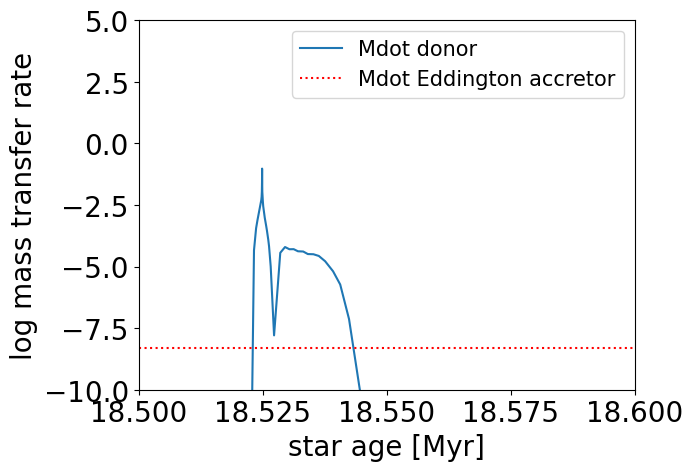

In [86]:

# Mdot donor
plt.plot(binary_history.age/1e6, binary_history.lg_mtransfer_rate, label = 'Mdot donor')

# Assuming Racc is the schwarschild radius
Mbh = 3.5*u.Msun
Mbh_kg = Mbh.to(u.kg)
Rsch = 2 * const.G * Mbh_kg / const.c**2
Rsch_msun = Rsch.to(u.Rsun)
print(Rsch, Rsch_msun)
Mdot_edd = 3.3 * 10**-4 * Rsch_msun.value

plt.axhline(np.log10(Mdot_edd), label = 'Mdot Eddington accretor', c= 'r', ls = ":")

plt.xlim(18.5,18.6)
plt.ylim(-10,5)
plt.xlabel('star age [Myr]',fontsize = 20)
plt.ylabel('log mass transfer rate', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize = 15)

plt.show()

The donors mass transfer rate much exceeds the eddington accretion rate

In [89]:
# donor_history.bulk_names

binary_history.bulk_names

('model_number',
 'age',
 'period_days',
 'binary_separation',
 'v_orb_1',
 'v_orb_2',
 'rl_1',
 'rl_2',
 'rl_relative_overflow_1',
 'rl_relative_overflow_2',
 'star_1_mass',
 'star_2_mass',
 'lg_mtransfer_rate',
 'lg_mstar_dot_1',
 'lg_mstar_dot_2',
 'lg_system_mdot_1',
 'lg_system_mdot_2',
 'lg_wind_mdot_1',
 'lg_wind_mdot_2',
 'eff_xfer_fraction',
 'J_orb',
 'Jdot',
 'jdot_mb',
 'jdot_gr',
 'jdot_ml',
 'jdot_ls',
 'jdot_missing_wind',
 'extra_jdot',
 'donor_index',
 'point_mass_index')

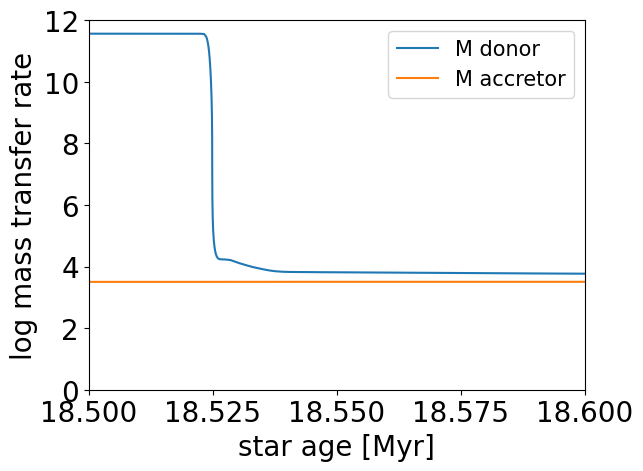

Delta accretor mass 0.0036629027663295233
Delta donor mass -8.610654193514645
Fractional accretion 0.04253919253996219 %


In [100]:
# How much mass did the donor star lose? 
# What fraction of this mass is accreted by the black hole and how much is lost from the system?


# Donor mass
plt.plot(binary_history.age/1e6, binary_history.star_1_mass, label = 'M donor')
plt.plot(binary_history.age/1e6, binary_history.star_2_mass, label = 'M accretor')

plt.xlim(18.5,18.6)
plt.ylim(0,12)
plt.xlabel('star age [Myr]',fontsize = 20)
plt.ylabel('log mass transfer rate', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize = 15)
plt.show()

dma = binary_history.star_2_mass[-1] - binary_history.star_2_mass[0]
dmd = binary_history.star_1_mass[-1] - binary_history.star_1_mass[0]
print(f"Delta accretor mass {dma}")
print(f"Delta donor mass {dmd}")
print(f"Fractional accretion {dma / abs(dmd) *100 } %")


We see that while the donor has lost 8 solar masses, the accretor has barely accreted anything. 

# 4. Future evolution? 

In [105]:
Mbh1 = binary_history.star_1_mass[-1]
Mbh2 = binary_history.star_2_mass[-1]
print(f" Donor mass at end of simulation {Mbh1}" )


 Donor mass at end of simulation 3.389344512779557


## a) 

we have a BBH system with the accretor still being about 3.5Msun, and the donor now being very similar in mass about 3.4Msun.


In [110]:
# Final separation
# binary_history.period_days[-1]
afinal =  binary_history.binary_separation[-1] # in Rsun


In [131]:
def tau_merge(a_Rsun, M1_Msun, M2_Msun):
    """
    tau = 1.503e8 yr * [1/(q(1+q))] * (a/Rsun)^4 * (M1/Msun)^(-3)

    ----------
    a  : separation assumed in Rsun
    M1 : primary mass assumed in in Msun
    """
    # Note that the actual peters formula is symmetric in mass, so it doesnt matter wchich is BH1 or 2
    q = M2_Msun/M1_Msun

    tau_yr = 1.503e8 * (1.0 / (q * (1.0 + q))) * (a_Rsun**4) * (M1_Msun**-3)
    return tau_yr 

print(f"Merger timescale = {tau_merge(afinal, Mbh2, Mbh1)*1e-9} Gyr ")


Merger timescale = 114.11613329690832 Gyr 


LVK will never see this! This is longer than the age of the universe. 